In [122]:
%matplotlib inline
import pandas as pd
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math
import os

from datasets import get_dataset, bruteforce
from distance import jaccard, l2
from lsh import LSHBuilder, LSH
from main import run_single_exp

plt.rcParams["figure.figsize"] =(20,10)
pd.options.display.max_rows = 2000
plt.rcParams['mathtext.fontset'] = 'cm'
#plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


sns.set(rc={'text.usetex' : True})
sns.set_style("whitegrid")


sns.set_context('paper', font_scale=5)

df = pd.read_csv("../exp-res/exp.csv").replace({
    "glove-100-angular" : "GLOVE",
    "movielens" : "MovieLens",
    "lastfm" : "LastFM",
    "sift-128-euclidean" : "SIFT",
    "mnist-784-euclidean" : "MNIST",
    "weighted_uniform": "weighted uniform",
    "approx_degree": "approx. degree"
})

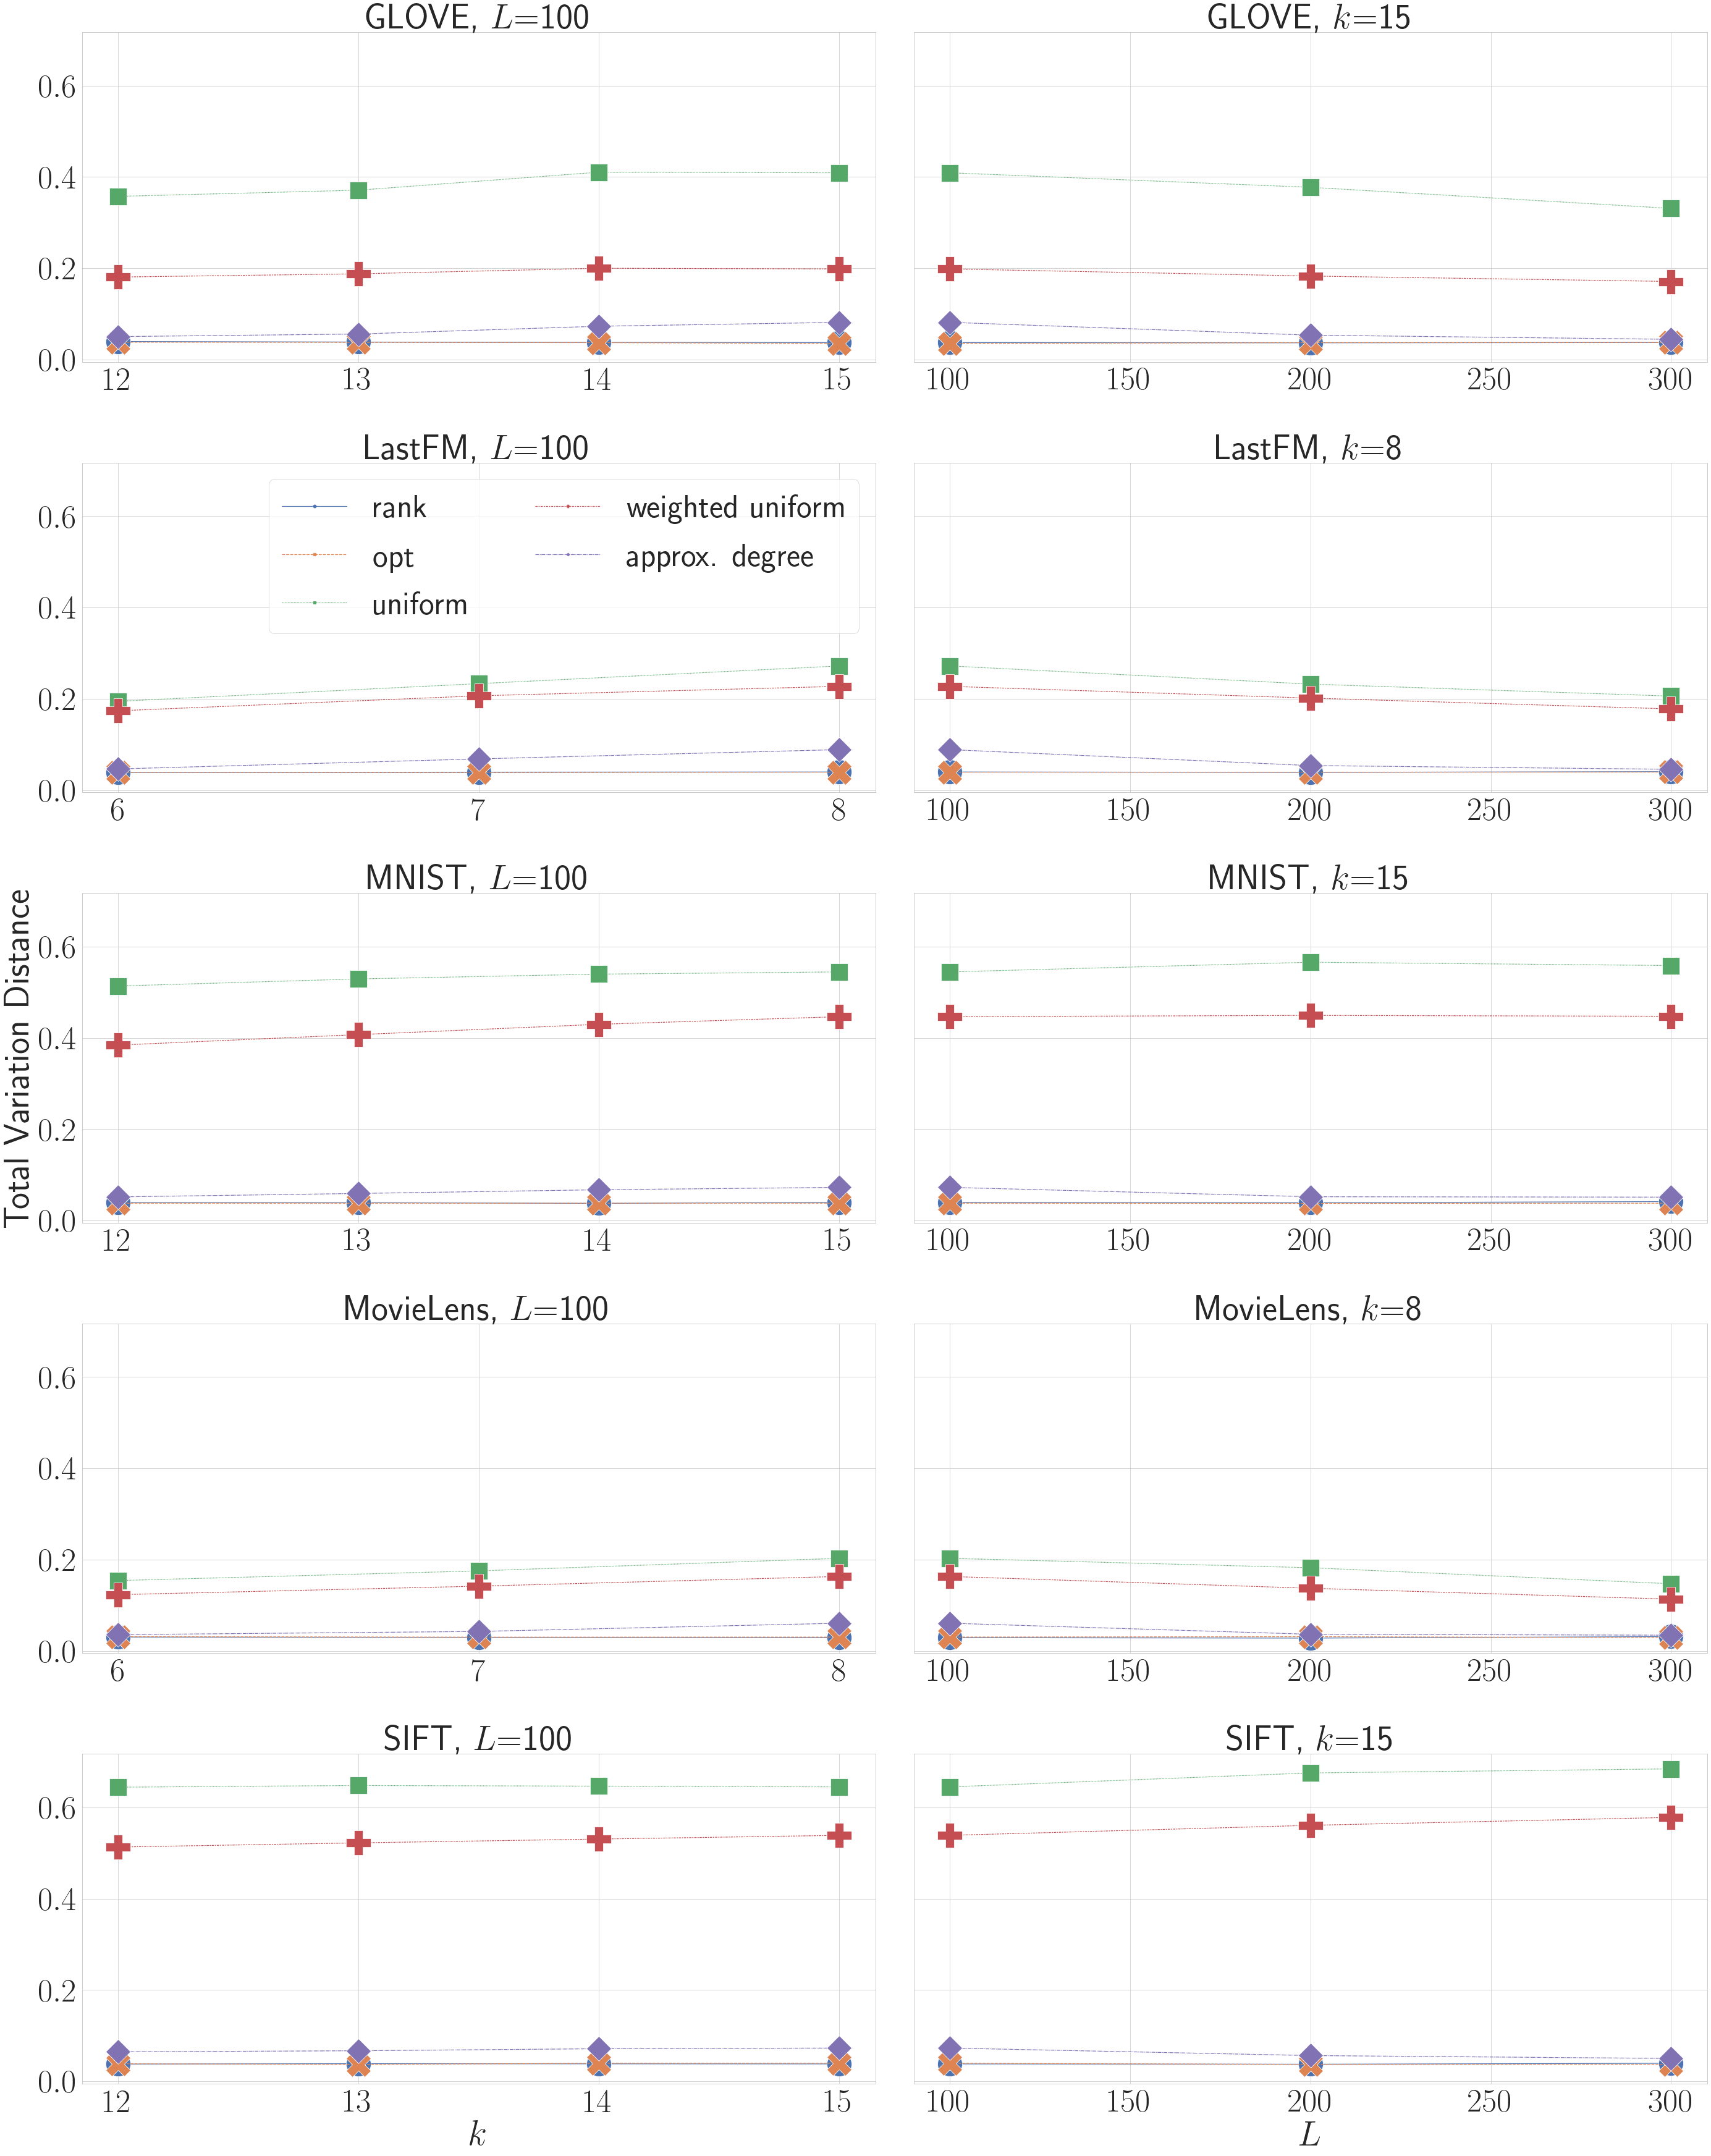

In [129]:
plt.rcParams["figure.figsize"] =(40,50)
sns.set_context('paper', font_scale=6)
fig, axs = plt.subplots(5, 2, sharey=True, sharex=False)
for i, ds in enumerate(sorted(set(df.dataset))):
    for k in set(df[df.dataset==ds].k):
        if len(set(df[(df.dataset==ds) & (df.k == k)].L.values)) > 1:
            #plt.title(f"{ds}, k={k}")
            axs[i,1].set_title(f"{ds}, $k$={k}")
            sns.lineplot(ax=axs[i,1], data=df[(df.k == k) & (df.dataset == ds)], x="L", y="tvd",style="method", hue="method", markers=True, ms=40, legend=False)

for i, ds in enumerate(sorted(set(df.dataset))):
    for L in set(df[df.dataset==ds].L):
        if len(set(df[(df.dataset==ds) & (df.L == L)].k.values)) > 1:
            #plt.title(f"{ds}, k={k}")
            axs[i,0].set_title(f"{ds}, $L$={L}")
            sns.lineplot(ax=axs[i,0], data=df[(df.L == L) & (df.dataset == ds)], x="k", y="tvd",style="method", hue="method", markers=True, ms=40, legend=(i == 1))#legend=(i == 2))
            #axs[i].set_xticklabels(map(int, set(df[(df.dataset==ds) & (df.L == L)].k.values)))
            axs[i,0].xaxis.set_major_locator(MaxNLocator(integer=True))


for ax in axs.flat:
    ax.set(xlabel="", ylabel="")

axs[2,0].set(ylabel='Total Variation Distance')
axs[4,1].set(xlabel='$L$')
axs[4,0].set(xlabel='$k$')

#plt.show()
axs[1,0].legend(ncol=2)
plt.tight_layout()
plt.savefig("plots/tvd.pdf")

# Discussion of b_cr/b_r term on real-world datasets

In [111]:
def ratio_plot(ds_name, distance_fn, rs, cs):
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=2.5)
    data, queries, _, _ = get_dataset(ds_name)
    groundtruth = bruteforce(data, queries, distance_fn)

    ball_df = pd.DataFrame(data={'r' : [], 'c' : [], 'br' : [], 'bcr' :[], 'i' : [] })

    for r in rs:
        for c in cs:
            for i in range(len(groundtruth)):
                if distance_fn == l2:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r * c])
                elif distance_fn == jaccard:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r * c])
                ball_df = ball_df.append({'r': r, 'c' : c, 'br': b_r, 'bcr' : b_cr, 'i' : i}, ignore_index=True)
                
                
    ball_grouped_df = ball_df.groupby(['r', 'c']).sum().reset_index()
    ball_grouped_df['rel'] = ball_grouped_df[['br', 'bcr']].apply(lambda x:  x[1] / x[0], axis=1)
    sns.catplot(data=ball_grouped_df[['r', 'c', 'rel']].round(2).rename(columns={'r': '$r$', 'c': '$c$', 'rel' : '$b_{cr} / b_r$'}),x='$c$', y='$b_{cr} / b_r$', kind='bar', col='$r$')
    plt.savefig(f"plots/{ds_name}_ratio_plot.pdf")

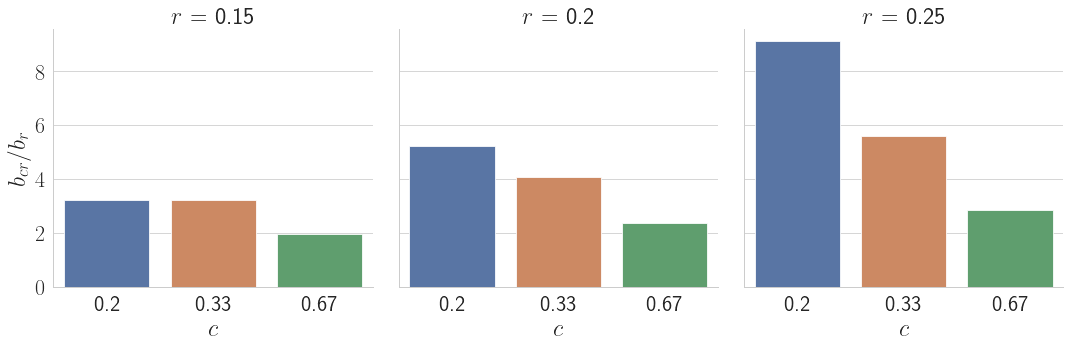

In [124]:
ratio_plot("lastfm", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

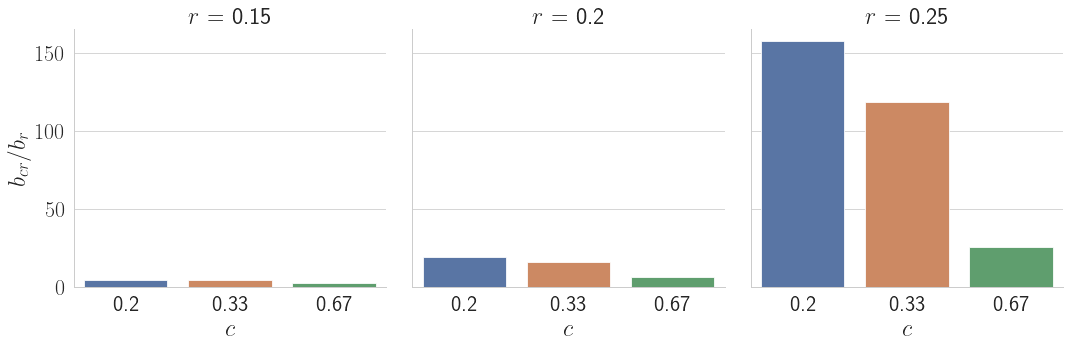

In [125]:
ratio_plot("movielens", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

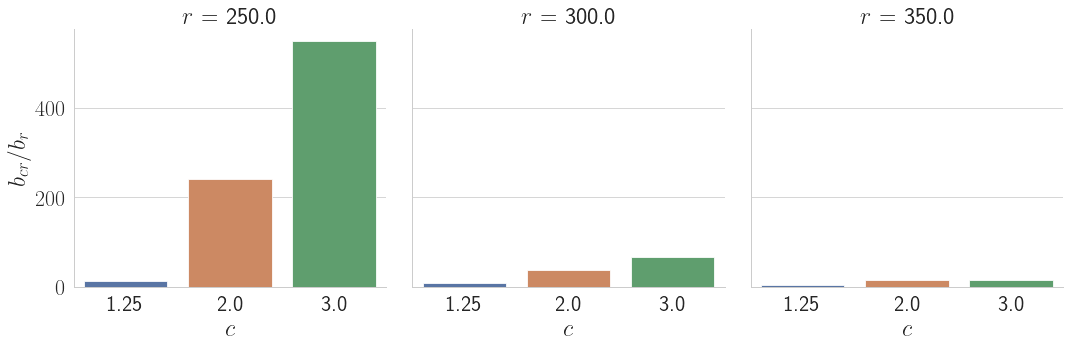

In [126]:
ratio_plot("sift-128-euclidean", l2, (250, 300, 350), (1.25, 2, 3))

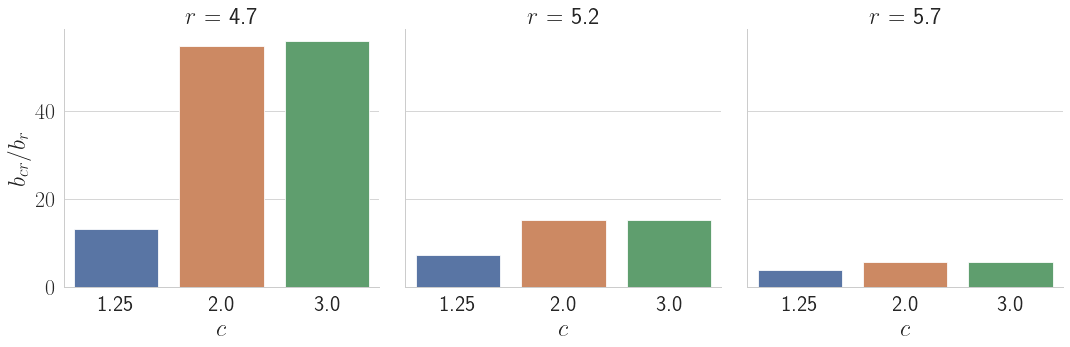

In [127]:
ratio_plot("glove-100-angular", l2, (4.7, 5.2, 5.7), (1.25, 2, 3))

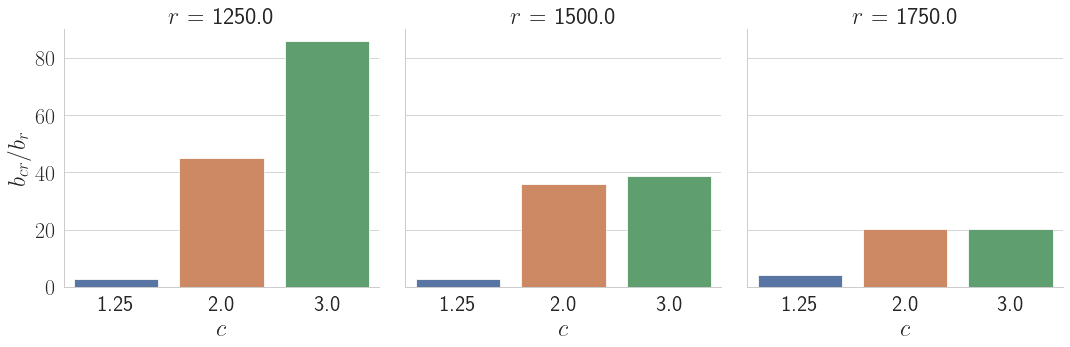

In [128]:
ratio_plot("mnist-784-euclidean", l2, (1250, 1500, 1750), (1.25, 2, 3))

# Fairness of the output

Produce plots that show individual fairness of the output

In [170]:
def produce_distribution_plot(res_fn,r=.15, scale=300):
    import pickle
    import collections
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=2.5)

    with open(res_fn, 'rb') as f:
        res = pickle.load(f)
    #print(res.keys())

    data, queries, _, _ = get_dataset(res["dataset"])

    #df = pd.DataFrame(columns=["query", "point", "freq", "sim"])

    df_dict = {
        "query": [],
        "point": [],
        "freq": [],
        "sim": []
    }

    for q, points in res["res"].items():
        # print(points)
        for point, count in collections.Counter(points).items():
            df_dict["query"].append(q) 
            df_dict["point"].append(point) 
            df_dict["freq"].append(count) 
            df_dict["sim"].append(l2(queries[q], data[point]))#jaccard(queries[q], data[point]))
    df = pd.DataFrame(data=df_dict)


    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

    #df = df[df.sim >= r]
    df = df[df.sim <= r]
    df = df.groupby(['query', 'sim']).mean().reset_index()

    
    norms = df.groupby(['query']).sum().reset_index()[['query', 'freq']]
    norms = norms.rename (columns={'freq' : 'norm'})
    df = df.merge(norms, left_on='query', right_on='query')
    df['relfreq'] = df[['freq', 'norm']].apply(lambda x: x[0] / x[1], axis=1)
    max_size = max(df.relfreq.values)

    sns.scatterplot(data=df.rename(
                columns={'query' : 'Query', 
                        'relfreq' : 'rel freq', 
                        'sim' : 'Similarity'}), 
                x='Similarity', y = 'Query', 
                hue='rel freq',
                size='rel freq', 
                sizes = (1, max_size * scale),
                palette=cmap
                )   
    leg = plt.legend()
    for t in leg.texts:
    # truncate label text to 4 characters
        t.set_text(t.get_text()[:4])
    #print(df)

    
    #print(norm)

    
    # plot_df['query_id'] = plot_df['query_id'].replace(dd)
    # norm = max(plot_df.groupby(['query_id']).sum().reset_index()[['query_time']].values)
    # #norm = 1
    
    # #plot_df = plot_df.merge(normalization_df, left_on = 'query_id', right_on = 'query_id')
    # plot_df['norm_count'] = plot_df[['query_time']].apply(lambda x: x / norm)
    
    
    # max_size = max(plot_df.norm_count.values)
    # sns.scatterplot(data=plot_df.rename(
    #                 columns={'query_id' : 'Query', 
    #                          'norm_count' : 'rel freq', 
    #                          'similarity' : 'Similarity'}), 
    #               x='Similarity', y = 'Query', 
    #               hue='rel freq',
    #               size='rel freq', 
    #               sizes = (1, max_size * scale),
    #               palette=cmap
    #              )   
    # leg = plt.legend()
    # for t in leg.texts:
    # # truncate label text to 4 characters
    #     t.set_text(t.get_text()[:4])
    # #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

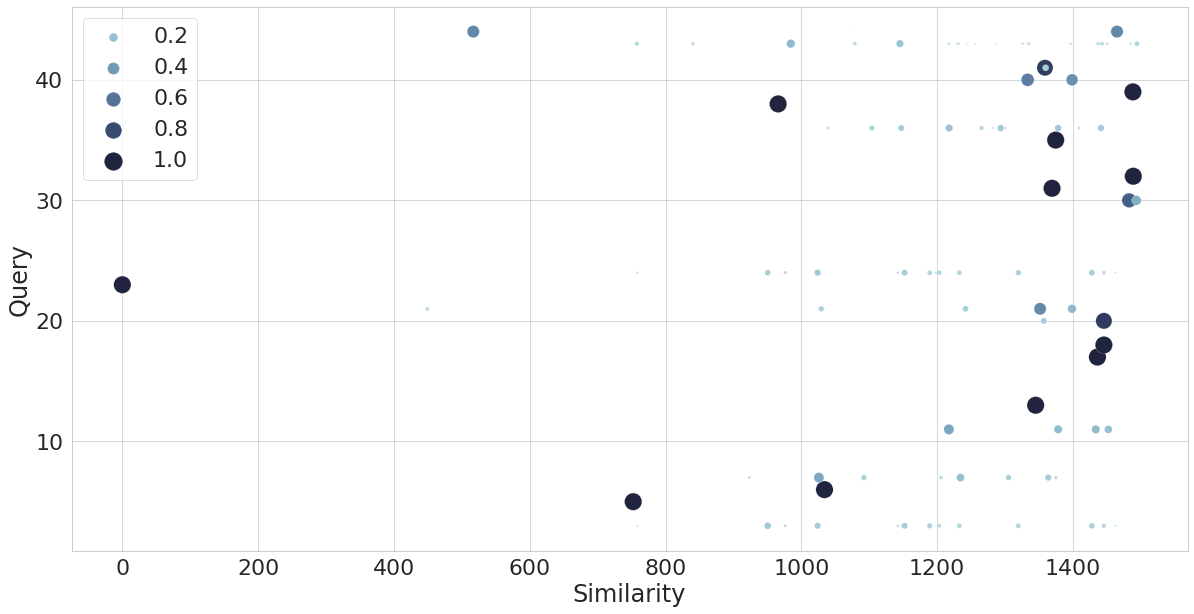

In [181]:
produce_distribution_plot(f"results/glove-100-angular/uniform/e2lsh/k_15_L_300_w_3700.pickle", r=1500)

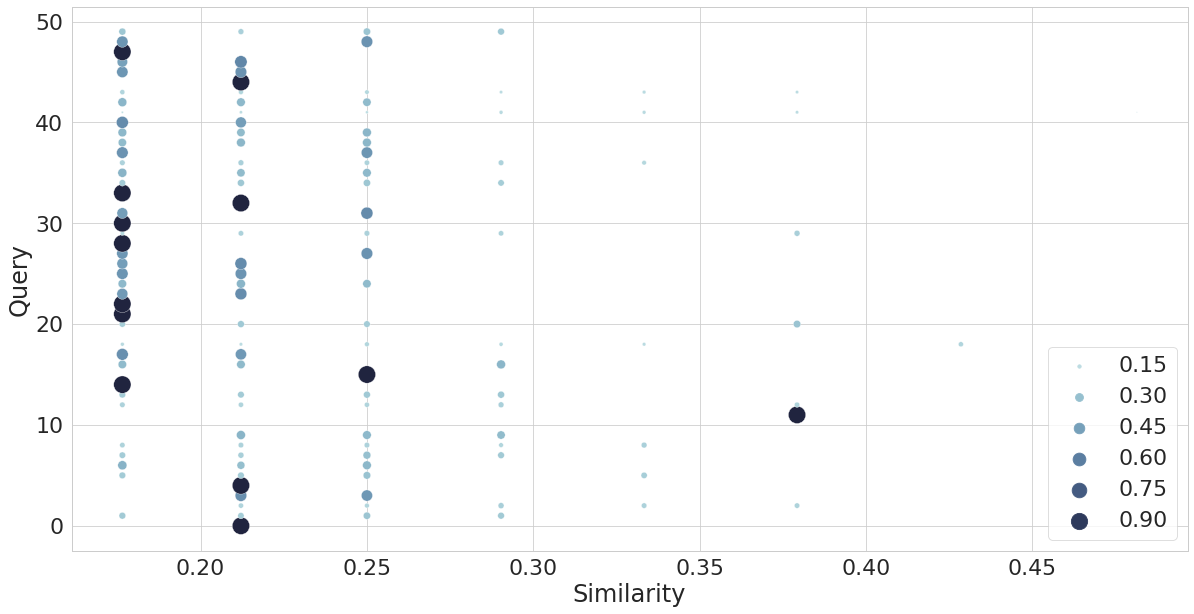

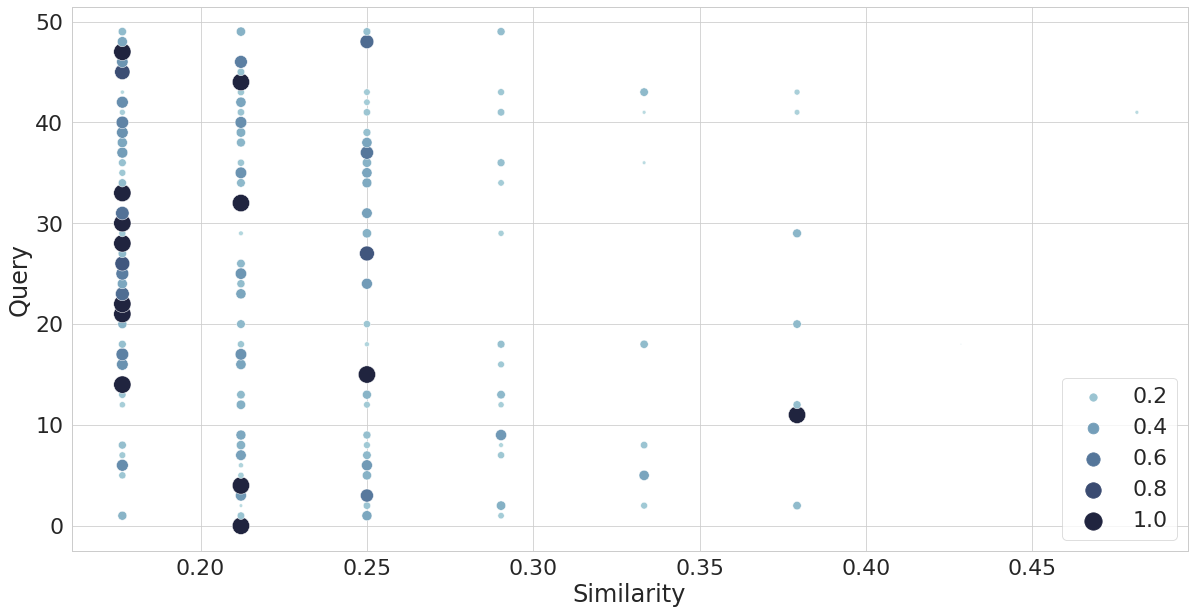

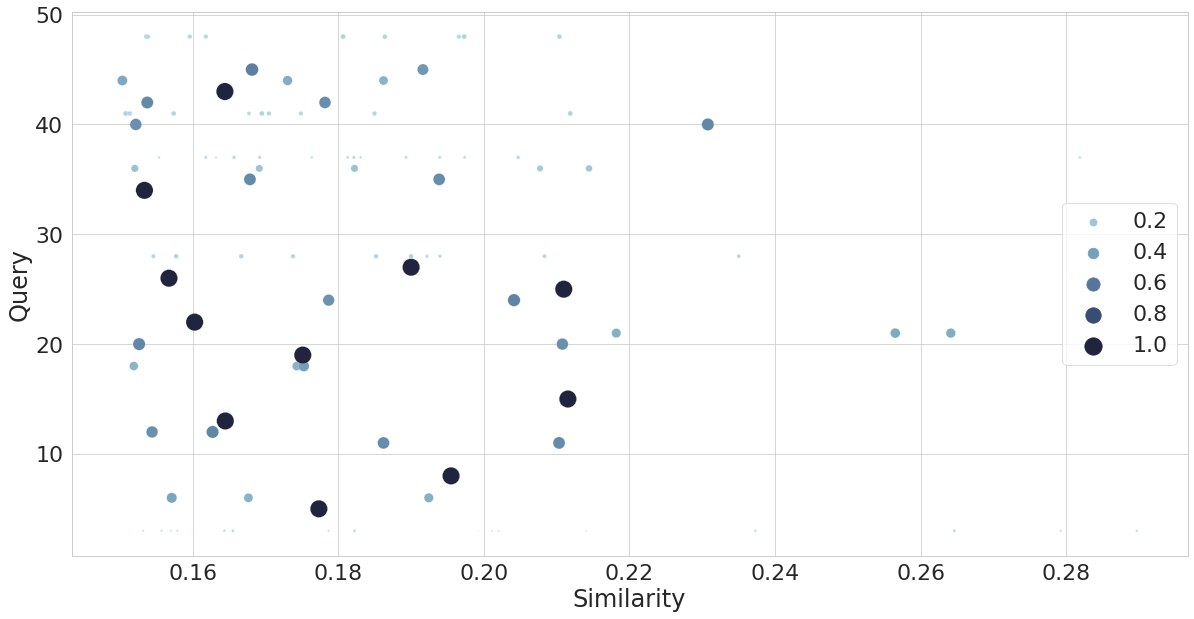

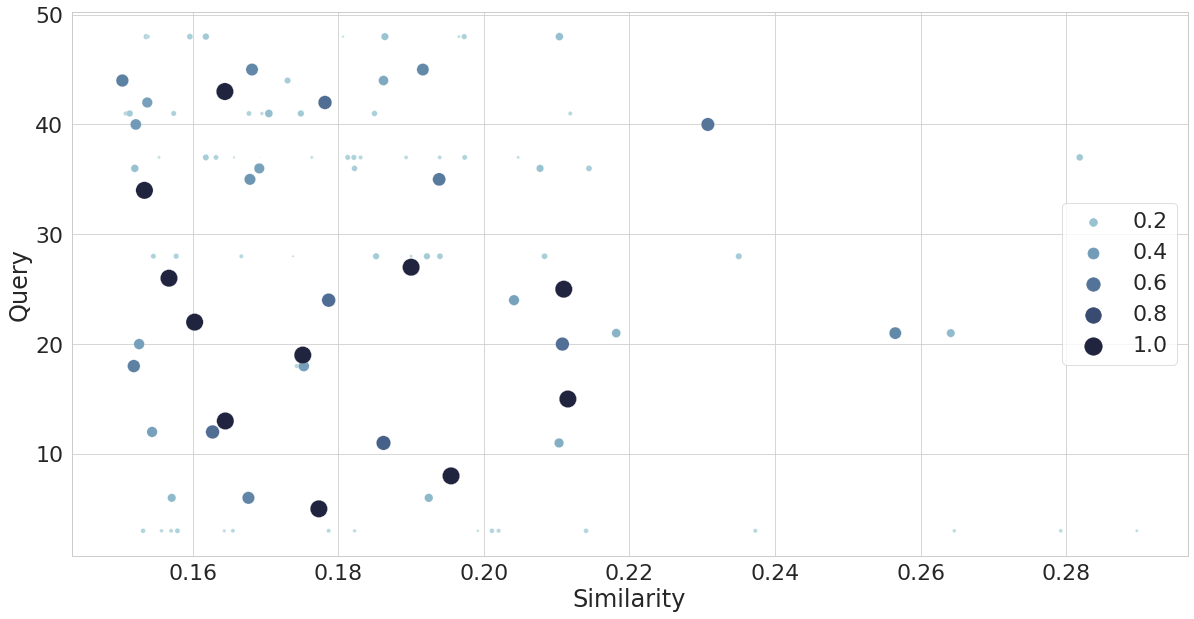

In [165]:
sns.set(rc={'text.usetex' : False})
sns.set_style("whitegrid")

exp_combinations = (('lastfm', 10, 500), ('movielens', 10, 500))
for ds, k, L in exp_combinations:
    for method in ["opt", "uniform"]:
        #if not os.path.isfile(f"results/{ds}/opt/onebitminhash/k_{k}_L_{L}.pickle"):
        #    run_single_exp(ds, 0, "onebitminhash", k, L, 0, False, False, 100)
        produce_distribution_plot(f"results/{ds}/{method}/onebitminhash/k_6_L_100.pickle")
        plt.show()

# Discussion: Approximate neighborhood is unfair?

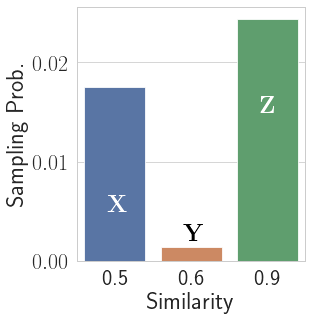

In [158]:
# Just run the experiment in here
import os

if not os.path.isfile("approx.csv"):
    import approx_exp
    approx_exp.run("approx.csv")

plt.rcParams["figure.figsize"] =(5,5)
sns.set_context('paper', font_scale=2.5)

df = pd.read_csv("approx.csv")
df['sim'] = [0.9, 0.6, 0.5]
df['prob'] = df[['count', 'runs']].apply(lambda x: x[0] / x[1], axis=1)

ax = sns.barplot(data=df.rename(columns={'sim': 'Similarity', 'prob' : 'Sampling Prob.'}), x='Similarity', y='Sampling Prob.')
ax.text(-0.1, 0.005, "$\mathbf{X}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(1.9, 0.015, "$\mathbf{Z}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(0.9, 0.002, "$\mathbf{Y}$", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.tight_layout()
plt.savefig("plots/sampling_prob.pdf")




# Running time experiments

Assumes that `run_running_time_experiments.sh` has been carried out before the analysis.

In [150]:
import glob
df = pd.DataFrame(columns=["dataset", "method", "tvd", "time"])

plt.rcParams["figure.figsize"] =(30,10)
sns.set_context('paper', font_scale=2.5)

for csv in glob.glob("../exp-res/*.out"):
    tmp_df = pd.read_csv(csv, names=["method", "tvd", "time"])
    tmp_df['dataset'] = csv.split("/")[-1].split("_")[0]
    df = df.append(tmp_df).replace({
        0 : "uniform",
        1 : "weighted uniform",
        2 : "exact degree",
        3 : "approx. degree",
        4 : "rank",
        "glove-100-angular-data" : "GLOVE",
        "sift-128-euclidean-data" : "SIFT", 
        "mnist-784-euclidean-data" : "MNIST"
    })

df

,dataset,method,tvd,time
0,GLOVE,uniform,0.402388,0.008782
1,GLOVE,weighted uniform,0.211306,0.010689
2,GLOVE,exact degree,0.038588,0.149252
3,GLOVE,approx. degree,0.093689,0.108474
4,GLOVE,rank,0.037508,0.167906
0,MNIST,uniform,0.611188,0.013152
1,MNIST,weighted uniform,0.484173,0.014488
2,MNIST,exact degree,0.039010,0.296927
3,MNIST,approx. degree,0.076155,0.161583
4,MNIST,rank,0.036925,0.111744


<Figure size 2160x720 with 0 Axes>

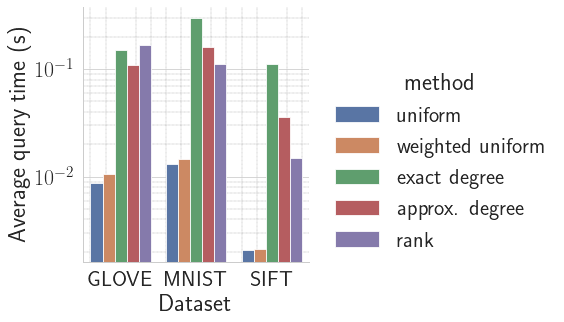

In [153]:
plt.clf()
g = sns.catplot(data=df[['method', 'time', 'dataset']], x="dataset", y="time", hue="method", kind="bar")
g.set_axis_labels("Dataset", "Average query time (s)")
plt.yscale('log')
g.ax.minorticks_on()
g.ax.grid(which='minor', linestyle=':', linewidth=0.3, color='black')
g.tight_layout()
plt.savefig('plots/running_time.pdf')